# Scale-Dependent Bias Modification

Initiate notebook.

In [1]:
import os
from collections import OrderedDict
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from nbodykit.lab import cosmology
from scipy.integrate import quad
from scipy.misc import derivative

In [2]:
FIDUCIAL_COSMOLOGY = cosmology.Planck15
r""":class:`nbodykit.cosmology.cosmology.Cosmology`: Default *Planck*15
cosmology.

"""

':class:`nbodykit.cosmology.cosmology.Cosmology`: Default *Planck*15\ncosmology.\n\n'

## Base cosmological model

Define the scale-dependence modification to bias per unit primordial non-Gaussianity per unit Lagrangian bias.

In [3]:
def scale_dependence_modification(redshift, cosmo=FIDUCIAL_COSMOLOGY):
    """Return the scale-dependence modification as a function of redshift.

    Parameters
    ----------
    redshift : float
        Redshift.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).

    Returns
    -------
    callable
        Scale-dependence modification as a function of wavenumber
        (in h/Mpc).
        
    """
    SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY = 1.686
    SPEED_OF_LIGHT_IN_HUNDRED_KM_PER_S = 2998.

    num_factors = 3 * (cosmo.h / SPEED_OF_LIGHT_IN_HUNDRED_KM_PER_S)**2 \
        * SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY * cosmo.Omega0_m
    transfer_func = cosmology.power.transfers.CLASS(cosmo, redshift)

    return lambda k: num_factors / transfer_func(k)

Define the general relativistic corrections as a function of redshift due to evolution and magnification of intrinsic
background tracer number density.

In [4]:
def general_relativistic_corrections(evolution_bias, magnification_bias,
                                     cosmo=FIDUCIAL_COSMOLOGY):
    """Return the general relativistic corrections as a function of 
    redshift.

    Parameters
    ----------
    evolution_bias, magnification_bias : callable
        Evolution bias or magnification bias as a function of redshift.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).

    Returns
    -------
    callable
        General relativistic correction as a function of redshift.

    """
    hubble_0 = 100 * cosmo.h
    background = cosmology.background.MatterDominated(cosmo.Omega0_m)
    
    scale_factor = lambda z: 1 / (1 + z)    
    conformal_hubble = lambda z: hubble_0 * background.E(scale_factor(z))
    log_conformal_hubble_derivative = lambda z: \
        scale_factor(z) + hubble_0 * background.E(scale_factor(z), order=1)
    
    return lambda z: log_conformal_hubble_derivative(z) \
        + (2 - 5*magnification_bias(z)) / cosmo.comoving_distance(z) \
        + conformal_hubble(z) * (5*magnification_bias(z) - evolution_bias(z))

## Luminosty function modeller

Generate parametric models for the luminosity function and perform related computations.

In [5]:
class LuminosityFunctionModeller:
    """Luminosity function modeller predicting the comoving number density
    and related quantities.
    
    Parameters
    ----------
    luminosity_model : callable
        Parametric luminosity function model with magnitude and redshift
        arguments and additional arguments (in that order).
    magnitude_limit : float
        Limiting magnitude.
    **model_parameters
        Keyword arguments to be passed to the specified parametric model.
        
    Attributes
    ----------
    luminosity_function : callable
        Luminosity function of magnitude and redshift (in that order).
    magnitude_limit : float
        Limiting magnitude.
    model_parameters : dict
        Model parameters.
    
    """
    
    def __init__(self, luminosity_model, magnitude_limit, 
                 **model_parameters):
            
        self.luminosity_function = lambda m, z: \
            luminosity_model(m, z, **model_parameters)
        self.magnitude_limit = magnitude_limit
        self.model_parameters = model_parameters
            
        self._comoving_number_density = None
        self._evolution_bias = None
        self._magnification_bias = None
        
    @classmethod
    def from_parameters_file(cls, luminosity_model, magnitude_limit, 
                             file_path):
        """Instantiate a modeller by reading parameter values from a file.
        
        Parameters
        ----------
        luminosity_model : callable
            Parametric luminosity function model with magnitude and
            redshift arguments and additional arguments (in that order).
        magnitude_limit : float
            Limiting magnitude.
        file_path : str
            Path of the model parameter file.
                
        """
        with open(file_path, 'r') as pfile:
            parameters = tuple(map(
                lambda var_name: var_name.strip(" "), 
                pfile.readline().strip("#").strip("\n").split(",")
            ))
            estimates = tuple(map(
                lambda value: float(value), 
                pfile.readline().split(",")
            ))
            
        return cls(
            luminosity_model, magnitude_limit, 
            **dict(zip(parameters, estimates))
        )
    
    @property
    def comoving_number_density(self):
        """Comoving number density as a function of redshift.
        
        Returns
        -------
        callable
        
        """
        if callable(self._comoving_number_density):
            return self._comoving_number_density
        
        self._comoving_number_density = lambda z: quad(
            self.luminosity_function,
            -40.,  # HINT: Rather than -inf for numerical stability.
            self.magnitude_limit,
            args=(z,)
        )[0]
        
        return self._comoving_number_density
    
    @property
    def evolution_bias(self):
        """Evolution bias as a function of redshift.
        
        Returns
        -------
        callable
        
        """
        if callable(self._evolution_bias):
            return self._evolution_bias
        
        ln_comoving_number_density = lambda z: np.log(
            self.comoving_number_density(z)
        )
        
        self._evolution_bias = lambda z: 3 - (1 + z) * derivative(
            ln_comoving_number_density, z, dx=1e-3
        )
        
        return self._evolution_bias
    
    @property
    def magnification_bias(self):
        """Magnification bias as a function of redshift.
        
        Returns
        -------
        callable
        
        """        
        if callable(self._magnification_bias):
            return self._magnification_bias
        
        lg_luminosity_function = lambda m, z: np.log10(
            self.luminosity_function(m, z)
        )
        
        self._magnification_bias = lambda z: derivative(
            lg_luminosity_function, 
            self.magnitude_limit,
            args=(z,), 
            dx=1e-2
        )
        
        return self._magnification_bias

Quasar luminosity function in the pure luminosity evolution model.

In [6]:
def quasar_luminosity_function_in_PLE_model(magnitude, redshift, 
                                            redshift_pivot=2.2, 
                                            **model_parameters_PLE):
    """Evaluate the pure luminosity evolution (PLE) model for the quasar
    luminosity function at the given absolute magnitude and redshift.
    
    Notes
    -----
    Magnitude is absolute and measured in :math:`g`-band normalised to
    the value at redshift 2.
    
    Parameters
    ----------
    magnitude : float
        Quasar magnitude.
    redshift : float
        Quasar redshift.
    redshift_pivot : float, optional
        Pivot redshift.
    **model_parameters_PLE
        PLE model parameters.
    
    Returns
    -------
    comoving_density : float :class:`numpy.ndarray`
        Predicted qausar comoving number density per unit magnitude.
        
    """    
    # Re-definitions.
    M_g, z, z_p = magnitude, redshift, redshift_pivot
    
    # Determine the redshift end.
    if z <= z_p:
        subscript = '\\textrm{{{}}}'.format('l')
    else:
        subscript = '\\textrm{{{}}}'.format('h') 
    
    # Set parameters.
    Phi_star = 10**model_parameters_PLE['\\log\\Phi^\\ast']
    M_g_star_p = model_parameters_PLE['M^\\ast_g(z_\\textrm{pivot})']
    
    alpha = model_parameters_PLE['\\alpha_{}'.format(subscript)]
    beta = model_parameters_PLE['\\beta_{}'.format(subscript)]
    k_1 = model_parameters_PLE['k_{{1{}}}'.format(subscript)]
    k_2 = model_parameters_PLE['k_{{2{}}}'.format(subscript)]
    
    # Evaluate the model prediction.
    exponent_magnitude_factor = M_g \
        - (M_g_star_p - 2.5*(k_1 * (z - z_p) + k_2 * (z - z_p)**2))
    try:
        faint_power_law = 10 ** (0.4*(alpha + 1) * exponent_magnitude_factor)
        bright_power_law = 10 ** (0.4*(beta + 1) * exponent_magnitude_factor)
    except OverflowError:
        print(exponent_magnitude_factor)
        raise OverflowError
    
    comoving_density = Phi_star / (faint_power_law + bright_power_law)
    
    return comoving_density

## Power spectrum modification

Power spectrum multipole modification as a function of scale and redshift.

In [7]:
def general_relativistic_multipole_modification(degree, wavenumber, redshift,
                                                correction_function,
                                                cosmo=FIDUCIAL_COSMOLOGY):
    """Power spectrum multipole modification by general relativistic
    corrections.
    
    Parameters
    ----------
    degree : int
        Degree of the multipole, ``degree >= 0``.
    wavenumber, redshift : float, array_like
        Wavenumber (in h/Mpc) and redshift.
    correction_function : callable
        General relativitic correction function.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
        
    Returns
    -------
    delta_P : float :class:`numpy.ndarray`
        Power spectrum multipole modification.
    
    """
    delta_amount = correction_function(redshift)**2 \
        * cosmo.scale_independent_growth_factor(redshift)**2 \
        * cosmology.LinearPower(cosmo, redshift)(wavenumber) / wavenumber**2
    
    pprint(delta_amount[0])
    
    pprint(degree == 0 or degree == 2)
    
    if degree == 0:
        delta_P = 1/3 * delta_amount
    elif degree == 2:
        delta_P = 2/3 * delta_amount
    else:
        delta_P = np.zeros(len(np.atleast_1d(wavenumber)))
        
    pprint(delta_P)
    
    return delta_P

In [8]:
def non_gaussianity_multipole_modification(degree, wavenumber, redshift,
                                           f_nl, b_1, modification_function,
                                           cosmo=FIDUCIAL_COSMOLOGY):
    """Power spectrum multipole modification by local primordial
    non-Gaussianity.
    
    Parameters
    ----------
    degree : int
        Degree of the multipole, ``degree >= 0``.
    wavenumber, redshift : float, array_like
        Wavenumber (in h/Mpc) and redshift.
    f_nl, b_1 : float
        Local primordial non-Gaussianity, scale-independent linear bias
        at the same redshift as `redshift`.
    modification_function : callable
        Scale-dependence modification at the same redshift as `redshift`
        as a function of wavenumber.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
        
    Returns
    -------
    delta_P : float :class:`numpy.ndarray`
        Power spectrum multipole modification.
    
    """
    delta_amount = f_nl / wavenumber**2 * (b_1 - 1) \
        * modification_function(redshift)(wavenumber)
    
    f = cosmo.scale_independent_growth_factor(redshift)
    
    if degree == 0:
        delta_P = (2*b_1 + 2/3*f) * delta_amount + delta_amount**2
    elif degree == 2:
        delta_P = 4/3 * f * delta_amount
    else:
        delta_P = np.zeros(len(np.atleast_1d(wavenumber)))
    
    delta_P *= cosmology.LinearPower(cosmo, redshift)(wavenumber)
    
    return delta_P

## Fiducial results

In [9]:
FIDUCIAL_REDSHIFT = 2.

FIDUCIAL_F_NL = 1.
FIDUCIAL_B_1 = 2.

FIDUCIAL_MAGNITUDE_LIMIT = -21.80

In [10]:
luminosity_model = LuminosityFunctionModeller.from_parameters_file(
    quasar_luminosity_function_in_PLE_model,
    FIDUCIAL_MAGNITUDE_LIMIT,
    "data/input/PLE_model_fits.txt"
)

correction_function = general_relativistic_corrections(
    luminosity_model.evolution_bias, 
    luminosity_model.magnification_bias
)

45166958791091.766
True
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

Text(0,0.5,'$\\Delta P_\\ell(k)$ [$(h/\\mathrm{Mpc})^3$]')

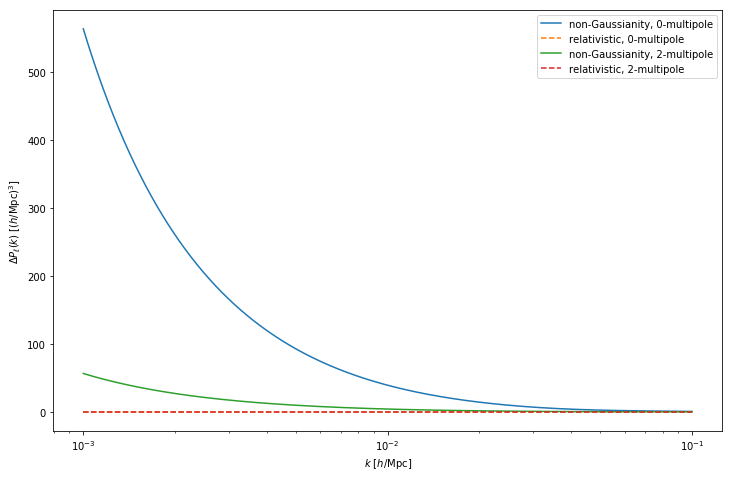

In [11]:
k = np.logspace(-3, -1, 1000)

plt.figure("Power spectrum multipole modification", figsize=(12, 7.75))
for ell in [0, 2]:
    delta_P_NG = non_gaussianity_multipole_modification(
        ell, k, FIDUCIAL_REDSHIFT, 
        FIDUCIAL_F_NL, FIDUCIAL_B_1, scale_dependence_modification
    )
    delta_P_GR = general_relativistic_multipole_modification(
        ell, k, FIDUCIAL_REDSHIFT, correction_function
    )
    plt.semilogx(k, delta_P_NG, ls='-', label="non-Gaussianity, {}-multipole".format(ell))
    plt.semilogx(k, delta_P_GR, ls='--', label="relativistic, {}-multipole".format(ell))

plt.legend()
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$\Delta P_\ell(k)$ [$(h/\mathrm{Mpc})^3$]")